In [90]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats

In [91]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 

    exclude: list of subject IDs that should be excluded from the final df 

    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [92]:

# path = "/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data"

# path = '/Users/prachi/Documents/depth_duration/target_at_center/january2022_data/VE_data'

path = '/Users/pmahableshwarkar/Documents/Depth_Project/DATA/0_2022_VE'

missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants before cleaning:  125
Number of participants with 10% or more missed trials:  4


#### Distribution of Unit Preferences

In [93]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  125


In [94]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit == "feet":
        feet_count += 1
    if unit == "meters":
        meters_count += 1
    
meters_count, feet_count

(30, 95)

In [95]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [96]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


In [97]:
# RT_cleaned_data

In [98]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [99]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [100]:
# outlier_cleaned_data

In [101]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [102]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.012648374164151 [0.7531620935410378, 12.050593496656605]
Avg Estim Cleaning: Number of Participants Removed 8


In [103]:
# avg_estim_cleaned_data

In [104]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [105]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(avg_estim_cleaned_data)

Number of participants removed: repeat responses:  8


In [106]:
# repeat_resp_cleaned_data

In [107]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [108]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  0
Number of participants left:  105


In [109]:
# find repeat sequences due to mturk glitch (so that N=192, as pre-registered) --> remove subject that was collected last 

all_subjects = cleaned_data.subjID.unique()
all_sequences = cleaned_data.sequenceName.unique()
for seq in all_sequences:
    seq_df = cleaned_data.loc[cleaned_data['sequenceName']== seq]
    seq_subjs = seq_df.subjID.unique()
    if len(seq_subjs) > 1:
        print(seq_subjs)
    

[467334 567839]
[679064 911073]
[675375 838133]
[875825 761733]
[551476 329210]
[698911 751172]
[152222 257518]
[808337 381112]
[512694 477529]
[366614 189255]


In [110]:
# remove participants
remove = []
for index, row in cleaned_data.iterrows():
    if row['subjID'] in remove:
        cleaned_data.drop(index, inplace=True)

In [111]:
final_data = cleaned_data.copy(deep=True)

In [112]:
len(final_data.subjID.unique())

105

In [113]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

2.3959238564563954

In [114]:
sampled_urls = final_data.url.unique()
# sampled_urls

#### Unit Distribution 

In [115]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

(90, 15)

Filter data by removing participants that used meters 

In [116]:
# for subj in final_subjects:
#     if subj not in feet_subjects:
#         print(subj)
#         final_data.drop(final_data.loc[final_data['subjID']==subj].index, inplace=True)

In [117]:
len(final_data.subjID.unique())

105

### Normalize Data by Participant's Avg 

In [118]:
def normalize_dfs(df):
    """
    Args:
        final data 
    Return:
        data normalized by participants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'

    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    norm_subjects = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    return normalized_df

In [119]:
normalized_data = normalize_dfs(final_data)

In [120]:
normalized_data_250 = normalized_data.loc[normalized_data['duration'] == 250]
normalized_data_1000 = normalized_data.loc[normalized_data['duration'] == 1000]


### Distribution of VE Estimates for a Discrimination Trial Pair

In [121]:
s0 = 'depth_duration_stimuli/001810_2014-06-26_20-51-35_260595134347_rgbf000040-resize_3/001810_2014-06-26_20-51-35_260595134347_rgbf000040-resize_3-target.png'

stimulus_0_df = normalized_data_250.loc[normalized_data_250['stimulus'] == s0]
stimulus_0_estims = list(stimulus_0_df['depth_estimate'])

s1 = 'depth_duration_stimuli/003010_2014-06-15_12-54-35_094959634447_rgbf000112-resize_0/003010_2014-06-15_12-54-35_094959634447_rgbf000112-resize_0-target.png'

stimulus_1_df = normalized_data_250.loc[normalized_data_250['stimulus'] == s1]
stimulus_1_estims = list(stimulus_1_df['depth_estimate'])


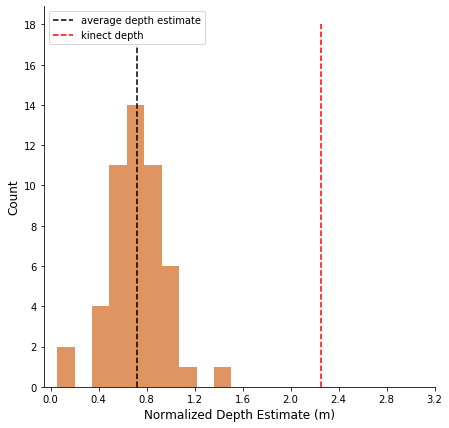

In [122]:
fig, ax = plt.subplots(figsize=[7,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.hist(stimulus_0_estims, color='chocolate', alpha=0.7)
# plt.hist(stimulus_0_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_0_estims))[:4], color='chocolate', alpha=0.7)
plt.vlines(x=[np.mean(stimulus_0_estims)], ymin=0, ymax=17, colors='black', ls='--', lw=1.5, label='average depth estimate')
plt.vlines(x=[2.25], ymin=0, ymax=18, colors='red', ls='--', lw=1.5, label='kinect depth')

plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,20,2))

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc=2)

plt.show()

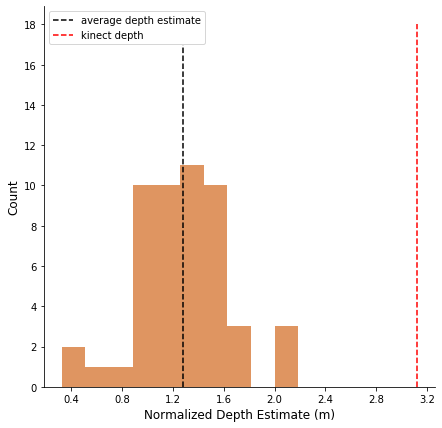

In [123]:
fig, ax = plt.subplots(figsize=[7,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

# plt.hist(stimulus_1_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_1_estims))[:4], color='chocolate', alpha=0.7)

plt.hist(stimulus_1_estims, color='chocolate', alpha=0.7)
plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,20,2))
plt.vlines(x=[np.mean(stimulus_1_estims)], ymin=0, ymax=17, colors='black', ls='--', lw=1.5, label='average depth estimate')
plt.vlines(x=[3.12], ymin=0, ymax=18, colors='red', ls='--', lw=1.5, label='kinect depth')

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc=2)

plt.show()

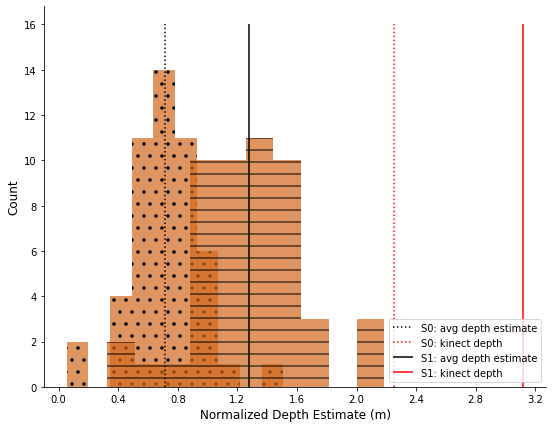

In [124]:
fig, ax = plt.subplots(figsize=[9,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.hist(stimulus_0_estims, color='chocolate', alpha=0.7, hatch='.')
# plt.hist(stimulus_0_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_0_estims))[:4], color='chocolate', alpha=0.7)
plt.vlines(x=[np.mean(stimulus_0_estims)], ymin=0, ymax=16, colors='black', ls='dotted', lw=1.5, label='S0: avg depth estimate')
plt.vlines(x=[2.25], ymin=0, ymax=16, colors='red', lw=1.5, label='S0: kinect depth', linestyles='dotted')

plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,20,2))

plt.hist(stimulus_1_estims, color='chocolate', alpha=0.7, hatch='-')
plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,20,2))
plt.vlines(x=[np.mean(stimulus_1_estims)], ymin=0, ymax=16, colors='black', ls='solid', lw=1.5, label='S1: avg depth estimate')
plt.vlines(x=[3.12], ymin=0, ymax=16, colors='red', ls='solid', lw=1.5, label='S1: kinect depth')

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc=4)

plt.show()

In [125]:
s0 = 'depth_duration_stimuli/001810_2014-06-26_20-51-35_260595134347_rgbf000040-resize_3/001810_2014-06-26_20-51-35_260595134347_rgbf000040-resize_3-target.png'

stimulus_0_df_1000 = normalized_data_1000.loc[normalized_data_1000['stimulus'] == s0]
stimulus_0_estims_1000 = list(stimulus_0_df_1000['depth_estimate'])

s1 = 'depth_duration_stimuli/003010_2014-06-15_12-54-35_094959634447_rgbf000112-resize_0/003010_2014-06-15_12-54-35_094959634447_rgbf000112-resize_0-target.png'

stimulus_1_df_1000 = normalized_data_1000.loc[normalized_data_1000['stimulus'] == s1]
stimulus_1_estims_1000 = list(stimulus_1_df_1000['depth_estimate'])


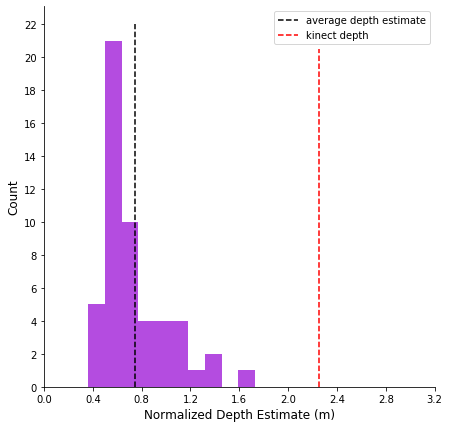

In [126]:
fig, ax = plt.subplots(figsize=[7,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.hist(stimulus_0_estims_1000, color='darkviolet', alpha=0.7)
# plt.hist(stimulus_0_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_0_estims))[:4], color='chocolate', alpha=0.7)
plt.vlines(x=[np.mean(stimulus_0_estims_1000)], ymin=0, ymax=22, colors='black', ls='--', lw=1.5, label='average depth estimate')
plt.vlines(x=[2.25], ymin=0, ymax=20.5, colors='red', ls='--', lw=1.5, label='kinect depth')

plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,24,2))

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc=1)

plt.show()

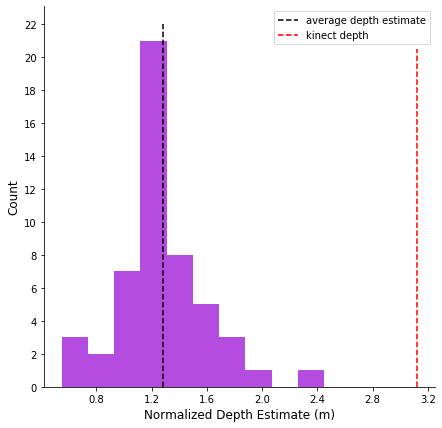

In [127]:
fig, ax = plt.subplots(figsize=[7,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

# plt.hist(stimulus_1_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_1_estims))[:4], color='chocolate', alpha=0.7)

plt.hist(stimulus_1_estims_1000, color='darkviolet', alpha=0.7)
plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,24,2))
plt.vlines(x=[np.mean(stimulus_1_estims_1000)], ymin=0, ymax=22, colors='black', ls='--', lw=1.5, label='average depth estimate')
plt.vlines(x=[3.12], ymin=0, ymax=20.5, colors='red', ls='--', lw=1.5, label='kinect depth')

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc=1)

plt.show()

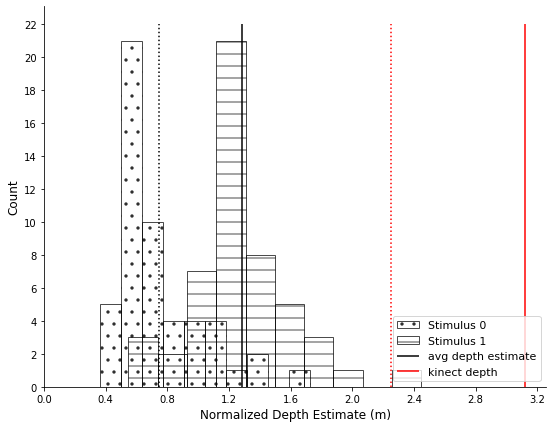

In [141]:
fig, ax = plt.subplots(figsize=[9,7])

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.hist(stimulus_0_estims_1000, fill= False, alpha=0.7, hatch='.', label='Stimulus 0')
# plt.hist(stimulus_0_estims, label='Avg Depth Estimate = ' + str(np.mean(stimulus_0_estims))[:4], color='chocolate', alpha=0.7)
plt.vlines(x=[np.mean(stimulus_0_estims_1000)], ymin=0, ymax=22, colors='black', ls='dotted', lw=1.5, )
plt.vlines(x=[2.25], ymin=0, ymax=22, colors='red', ls='dotted', lw=1.5)

plt.hist(stimulus_1_estims_1000, fill=False, alpha=0.7, hatch='-', label='Stimulus 1')
plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,24,2))
plt.vlines(x=[np.mean(stimulus_1_estims_1000)], ymin=0, ymax=22, colors='black', ls='solid', lw=1.5, label='avg depth estimate')
plt.vlines(x=[3.12], ymin=0, ymax=22, colors='red', ls='solid', lw=1.5, label='kinect depth')

plt.xticks(np.arange(0,3.4,0.4))
plt.yticks(np.arange(0,24,2))

plt.xlabel('Normalized Depth Estimate (m)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc=4, prop={'size': 11})

plt.show()

#### Age

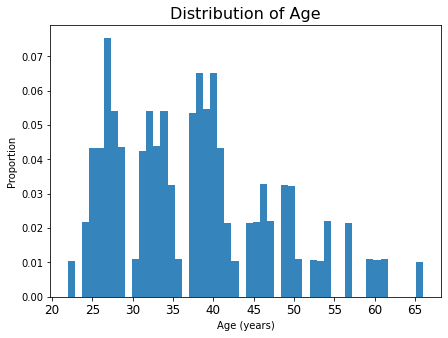

In [30]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 5) ,fontsize=12)
# plt.yticks([])
plt.xlabel('Age (years)')
plt.ylabel('Proportion')
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.9)
plt.show()


In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


In [32]:
def AnovaRM_subjectData(df, durations):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        for duration in durations:
            duration_subj_df = subj_df
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df


In [33]:
final_data_250 = final_data.loc[final_data["duration"]  == 250]
final_data_1000 = final_data.loc[final_data["duration"]  == 1000]

In [34]:
slopes_250, df_intercept_250 = AnovaRM_subjectData(final_data_250, [250])
slopes_1000, df_intercept_1000 = AnovaRM_subjectData(final_data_1000, [1000])



### Duration x Avg Participant Slope

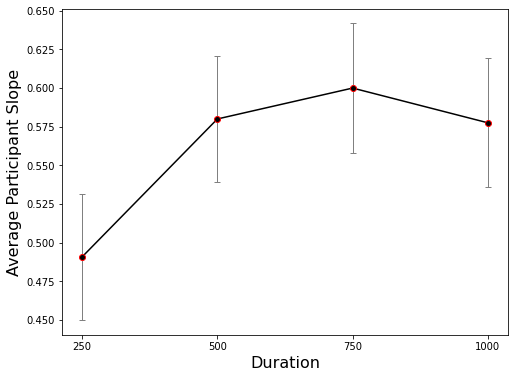

In [35]:
avg_slope_250 = np.mean(np.array(slopes_250['slope']))
ste_avg_slope_250 = stats.sem(np.array(slopes_250['slope']))

avg_slope_1000 = np.mean(np.array(slopes_1000['slope']))
ste_avg_slope_1000 = stats.sem(np.array(slopes_1000['slope']))

avg_stes = [ste_avg_slope_250, ste_avg_slope_250, ste_avg_slope_1000, ste_avg_slope_1000]
avgslopes = [avg_slope_250, 0.58, 0.6, avg_slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 6])
plt.plot(xAxis,avgslopes, color="black")
plt.errorbar(xAxis, avgslopes, yerr=avg_stes, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "red", capsize = 3)

plt.xlabel('Duration', fontsize=16)
plt.ylabel('Average Participant Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

In [36]:
avg_slope_250, avg_slope_1000

(0.49073422398265437, 0.5775054908563145)

#### Distribution of Participant Average Estimates

In [37]:
all_subjIDs = final_data.subjID.unique()
avgs = []
for subj in all_subjIDs:
    subj_df = final_data.loc[final_data['subjID'] == subj]
    subj_avg = np.array(subj_df['depth_estimate']).mean()
    avgs.append(subj_avg)
    if subj_avg > 11:
        print(subj)
    
# 9-6-2021_6-48-58_485648.csv
# 9-6-2021_7-13-44_277612.csv
# 9-6-2021_7-48-11_153554.csv

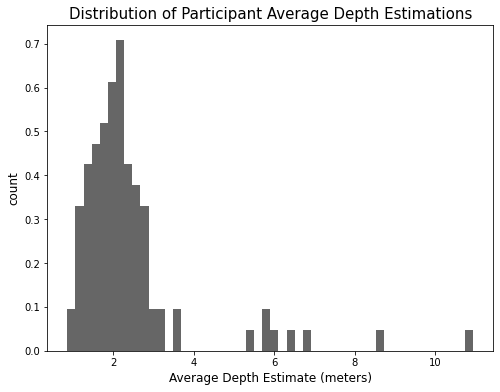

In [38]:
plt.figure(figsize = [8,6])
plt.title("Distribution of Participant Average Depth Estimations", fontsize = 15)
plt.ylabel("count", fontsize = 12)
plt.xlabel("Average Depth Estimate (meters)", fontsize = 12)
_, bins, _ = plt.hist(avgs, 50, density=1, alpha=0.6, color = 'black')
mu, sigma = scipy.stats.norm.fit(avgs)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line, color = 'orange')

plt.show()

### Data split by duration

In [39]:
data_250ms = final_data[final_data['duration'] == 250]
data_1000ms = final_data[final_data['duration'] == 1000]

duration_data = [data_250ms, data_1000ms]

n_data_250ms = normalized_data[normalized_data['duration'] == 250]
n_data_1000ms = normalized_data[normalized_data['duration'] == 1000]

normalized_duration_data = [n_data_250ms, n_data_1000ms]


In [36]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/matched/'
durations = ['250', '1000']

for i in range(len(duration_data)):  
    duration_data[i].to_csv(dest + 'raw_' + durations[i] + '_data.csv' , index=True)
    normalized_duration_data[i].to_csv(dest + 'normalized_' + durations[i] + '_data.csv' , index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/matched/raw_250_data.csv'

# Individual Target Results


In [40]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [41]:
raw_trial_pivot = trial_pivotTable(duration_data)
normalized_trial_pivot = trial_pivotTable(normalized_duration_data)

In [130]:
type(raw_trial_pivot[0]['Average Estimated Depth'])

pandas.core.series.Series

In [118]:
# raw_trial_pivot[0].loc[raw_trial_pivot[0]['stimulus'] == s0]

In [42]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)

    return xs, ys, stes, actualdepths, stds

In [43]:
trial_raw_final = trial_getxy(raw_trial_pivot)
trial_normalized_final = trial_getxy(normalized_trial_pivot)

### Raw Data

In [44]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]
std_250 = trial_plot_data[4][0]


final_x_1000 = trial_plot_data[0][1]
final_y_1000 = trial_plot_data[1][1]
ste_1000 = trial_plot_data[2][1]
stim_1000 = trial_plot_data[3][1]
std_1000 = trial_plot_data[4][1]

In [51]:
final_x_250.index('depth_duration_stimuli/000368_2014-06-09_15-53-01_260595134347_rgbf000155-resize_2/000368_2014-06-09_15-53-01_260595134347_rgbf000155-resize_2-target.png')

final_x_250[70], stim_250[70], final_y_250[70]

('depth_duration_stimuli/000368_2014-06-09_15-53-01_260595134347_rgbf000155-resize_2/000368_2014-06-09_15-53-01_260595134347_rgbf000155-resize_2-target.png',
 2.4860000000000015,
 1.5552549019607849)

m: [0.48732363]
b: 0.7053770550067895
R-squared:  0.6620114256959317


0.662

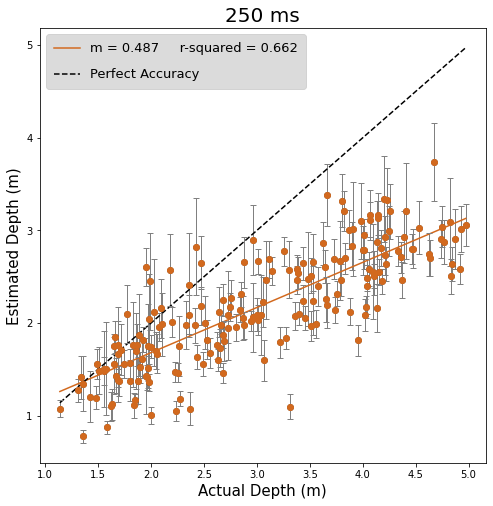

In [45]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

In [ ]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

### Normalized

In [ ]:
norm_trial_plot_data = trial_normalized_final

## Execute this cell to prep for plotting
n_final_x_250 = norm_trial_plot_data[0][0]
n_final_y_250 = norm_trial_plot_data[1][0]
n_ste_250 = norm_trial_plot_data[2][0]
n_stim_250 = norm_trial_plot_data[3][0]
n_std_250 = norm_trial_plot_data[4][0]

n_final_x_1000 = norm_trial_plot_data[0][1]
n_final_y_1000 = norm_trial_plot_data[1][1]
n_ste_1000 = norm_trial_plot_data[2][1]
n_stim_1000 = norm_trial_plot_data[3][1]
n_std_1000 = norm_trial_plot_data[4][1]

In [ ]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_250 = np.array(stim_250).reshape(-1,1)
n_y_250 = n_final_y_250
n_reg_250 = LinearRegression().fit(n_X_250, n_y_250)

#Generated Predictions
n_y_predicted_250 = n_reg_250.predict(n_X_250)
#Plot Our Actual and Predicted Values
plt.plot(n_X_250, n_y_250, 'o', color='black', alpha = 0.5);
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = 'm = ' + str(round(n_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_250.score(n_X_250, n_y_250)), 3)))
plt.title("Normalized: 250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_250, n_X_250/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_250, n_y_250, yerr=n_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(n_reg_250.coef_))
print("b: {0}".format(n_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_250.score(n_X_250, n_y_250))

round(float(n_reg_250.score(n_X_250, n_y_250)), 3)

In [ ]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_1000 = np.array(n_stim_1000).reshape(-1,1)
n_y_1000 = n_final_y_1000
n_reg_1000 = LinearRegression().fit(n_X_1000, n_y_1000)

#Generated Predictions
n_y_predicted_1000 = n_reg_1000.predict(n_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(n_X_1000, n_y_1000, 'o', color='black', alpha = 0.7);
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(n_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_1000.score(n_X_1000, n_y_1000)), 3)))

plt.title("Normalized: 1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_1000, n_y_1000, yerr=n_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_1000.coef_))
print("b: {0}".format(n_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_1000.score(n_X_1000, n_y_1000))

In [ ]:
# Save data arrays to a binary file in NumPy .npy format. 

n_destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_npy_files/matchedVE/normalized/'

with open(n_destpath + 'n_X_250.npy', 'wb') as f:
    np.save(f, n_X_250)
with open(n_destpath + 'n_final_y_250.npy', 'wb') as f:
    np.save(f, n_final_y_250)
    
with open(n_destpath + 'n_X_1000.npy', 'wb') as f:
    np.save(f, n_X_1000)
with open(n_destpath + 'n_final_y_1000.npy', 'wb') as f:
    np.save(f, n_final_y_1000)

with open(n_destpath + 'n_std_250.npy', 'wb') as f:
    np.save(f, n_std_250)
    
with open(n_destpath + 'n_std_1000.npy', 'wb') as f:
    np.save(f, n_std_1000)
    
with open(n_destpath + 'n_ste_250.npy', 'wb') as f:
    np.save(f, n_ste_250)
    
with open(n_destpath + 'n_ste_1000.npy', 'wb') as f:
    np.save(f, n_ste_1000)

with open(n_destpath + 'n_final_stim_250.npy', 'wb') as f:
    np.save(f, n_final_x_250)

with open(n_destpath + 'n_final_stim_1000.npy', 'wb') as f:
    np.save(f, n_final_x_1000)